In [2]:
%pip install nfl_data_py

Note: you may need to restart the kernel to use updated packages.


In [1]:
import nfl_data_py as nfl
import numpy as np

In [2]:
df = nfl.import_pbp_data(list(range(2000, 2021)))

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
Downcasting floats.


In [3]:
df['label'] = np.select(
                        [
                            (df['result'] > 0) & (df['posteam'] == df['home_team']),
                            (df['result'] < 0) & (df['posteam'] == df['away_team'])
                        ],
                        [1, 1],
                        default = 0
                       )
df['is_home'] = (df['posteam'] == df['home_team']).astype(int)


/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_59191/4024926356.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['label'] = np.select(
/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_59191/4024926356.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_home'] = (df['posteam'] == df['home_team']).astype(int)


In [4]:
df = df[(df['result'] != 0) & (df['qtr'] <= 4)]

# If the starting posteam recieves the second half kick off
df.loc[(df['qtr'] <= 2) & (df['posteam'] == df['defteam'].dropna().iloc[0]), 'recieve_2h_ko'] = 1
df.loc[~((df['qtr'] <= 2) & (df['posteam'] == df['defteam'].dropna().iloc[0])), 'recieve_2h_ko'] = 0

# Convert to the posteam for spread
df['posteam_spread'] = np.where(df['is_home'] == 1, df['spread_line'], -1 * df['spread_line'])
df['elapsed_share'] = (3600 - df['game_seconds_remaining']) / 3600

# Exponential decay of the spread. It weighs more towards the start
df['spread_time'] = df['posteam_spread'] * np.exp(-4*df['elapsed_share']) # Weights the posteam spread over time



/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_59191/2883950221.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[(df['qtr'] <= 2) & (df['posteam'] == df['defteam'].dropna().iloc[0]), 'recieve_2h_ko'] = 1
/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_59191/2883950221.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['posteam_spread'] = np.where(df['is_home'] == 1, df['spread_line'], -1 * df['spread_line'])
/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_59191/2883950221.py:9: Per

In [16]:
model_data = df[[
    # Explanatory variables
    'label', 'game_id', 'season',
    
    
    # Features
    'recieve_2h_ko', 'spread_time', 'is_home', 'half_seconds_remaining', 'game_seconds_remaining', 
    'score_differential','down', 'ydstogo', 'yardline_100', 
    'posteam_timeouts_remaining', 'defteam_timeouts_remaining'
    
    
]]

In [22]:
model_data.dropna(inplace=True)
model_data.reset_index(drop=True, inplace=True)

/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_59191/70319802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.dropna(inplace=True)


In [3]:
import pandas as pd
model_data = pd.read_csv('nfl-pred-data.csv')

In [4]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825980 entries, 0 to 825979
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   label                       825980 non-null  int64  
 1   game_id                     825980 non-null  object 
 2   season                      825980 non-null  int64  
 3   recieve_2h_ko               825980 non-null  float64
 4   spread_time                 825980 non-null  float64
 5   is_home                     825980 non-null  int64  
 6   half_seconds_remaining      825980 non-null  float64
 7   game_seconds_remaining      825980 non-null  float64
 8   score_differential          825980 non-null  float64
 9   down                        825980 non-null  float64
 10  ydstogo                     825980 non-null  float64
 11  yardline_100                825980 non-null  float64
 12  posteam_timeouts_remaining  825980 non-null  float64
 13  defteam_timeou

In [5]:
model_data.describe()

,label,season,recieve_2h_ko,spread_time,is_home,half_seconds_remaining,game_seconds_remaining,score_differential,down,ydstogo,yardline_100,posteam_timeouts_remaining,defteam_timeouts_remaining
count,825980.000000,825980.000000,825980.000000,825980.000000,825980.000000,825980.000000,825980.000000,825980.000000,825980.000000,825980.000000,825980.000000,825980.000000,825980.000000
mean,0.506740,2010.052588,0.016002,0.024016,0.501619,841.178009,1742.001758,-1.219128,2.004084,8.573574,51.677082,2.534330,2.555625
std,0.499955,6.040141,0.125481,2.179396,0.499998,543.181983,1045.883784,10.829659,1.006519,4.096829,24.388046,0.772454,0.741000
min,0.000000,2000.000000,0.000000,-27.000000,0.000000,0.000000,0.000000,-59.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,2005.000000,0.000000,-0.520068,0.000000,345.000000,843.000000,-7.000000,1.000000,6.000000,33.000000,2.000000,2.000000
50%,1.000000,2010.000000,0.000000,0.022148,1.000000,835.000000,1801.000000,0.000000,2.000000,10.000000,55.000000,3.000000,3.000000
75%,1.000000,2015.000000,0.000000,0.564060,1.000000,1312.000000,2630.000000,4.000000,3.000000,10.000000,72.000000,3.000000,3.000000
max,1.000000,2020.000000,1.000000,25.569300,1.000000,1800.000000,3600.000000,59.000000,4.000000,50.000000,99.000000,3.000000,3.000000


In [6]:
train_data = model_data[model_data['season'] < 2019]
test_data = model_data[model_data['season'] >= 2019]

In [8]:
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score


model = XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss',
                     monotone_constraints = (0, 0, 0, 0, 0, 1, -1, -1, -1, 1, -1))
groups = train_data['game_id']

X = train_data.drop(columns=['label', 'game_id', 'season'])
y = train_data['label']


folds = GroupKFold(n_splits = 5)
scores = []

for train_idx, test_idx in folds.split(X, y, groups = groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    
    scores.append(score)
    



In [9]:
scores

[0.7715215382761345,
 0.7746244074877481,
 0.7719582493656394,
 0.7778216681619153,
 0.7789187778885328]

In [10]:
sum(scores) / len(scores)

0.774968928235994

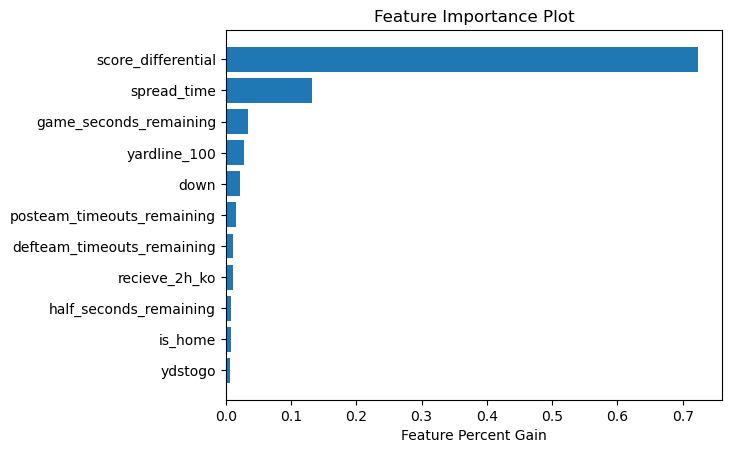

In [28]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = model.feature_importances_
sorted_idx = np.argsort(feature_importances)
features = X.columns[sorted_idx]

plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align = 'center')
plt.yticks(range(len(sorted_idx)), features)
plt.title('Feature Importance Plot')
plt.xlabel('Feature Percent Gain')
plt.show()

In [38]:
y_pred = model.predict_proba(test_data[model.feature_names_in_])[:, 1]

In [59]:
from sklearn.metrics import log_loss, roc_curve, auc
y_test = test_data['label']

print('Log Loss', log_loss(y_test, y_pred))


Log Loss 0.43365031030696166


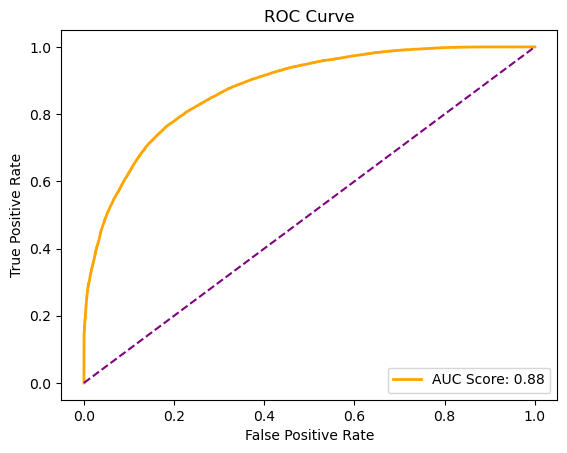

In [68]:
ac = auc(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, y_pred)


plt.plot(fpr, tpr, color = 'orange', lw=2, label = f'AUC Score: {ac:0.2f}') # Area under the curve
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'purple')
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [70]:
test_data['wp'] = y_pred

/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_47343/462790352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['wp'] = y_pred


In [72]:
test_data['home_wp'] = np.where(test_data['is_home'] == 1, test_data['wp'], 1 - test_data['wp'])

/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_47343/1885600542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['home_wp'] = np.where(test_data['is_home'] == 1, test_data['wp'], 1 - test_data['wp'])


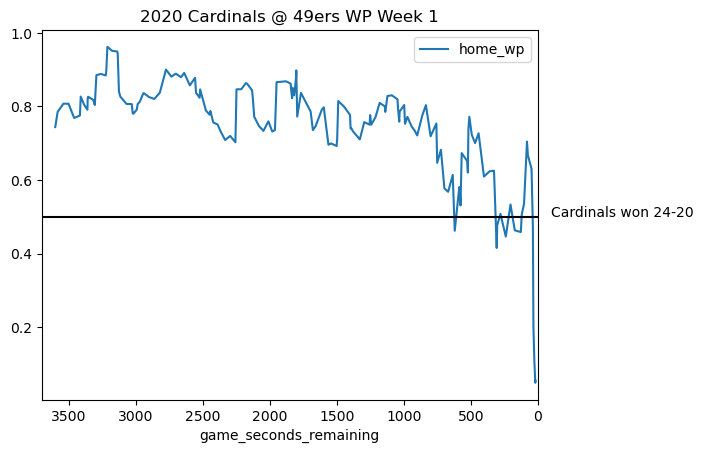

In [87]:
test_data[test_data['game_id'] == '2020_01_ARI_SF'].plot(x='game_seconds_remaining', y = 'home_wp')

plt.axhline(y=0.5, color = 'black')

plt.xlim(3700, 0)

plt.title('2020 Cardinals @ 49ers WP Week 1')
plt.text(-100, 0.5, 'Cardinals won 24-20')
plt.show()